In [1]:
import numpy as np
import pandas as pd
import os
import pickle

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
cv_input_data_file = os.path.join(data_dir, f"cv_input/zscore_noRx.npy")
with open(cv_input_data_file, 'rb') as mfile:
    Ztrue = np.load(mfile)
    Z = np.load(mfile)
    Zmask = np.load(mfile)
    
rseq = np.loadtxt("/gpfs/commons/home/sbanerjee/work/npd/PanUKB/jobs/cross_validation/rseq.txt")
rseq = np.append(rseq, np.loadtxt("/gpfs/commons/home/sbanerjee/work/npd/PanUKB/jobs/cross_validation/rseq_fine.txt"))
rseq = np.sort(rseq)

cvout_dir = "/gpfs/commons/home/sbanerjee/npddata/panukb/cross_validation/noRx"

In [3]:
models = dict()
for rthres in rseq:
    rthres_int = int(rthres)
    rstr = f"{rthres_int:d}"
    cvout_file = os.path.join(cvout_dir, f"nnm_model_r{rstr}.pkl")
    # print(cvout_file)
    with open(cvout_file, "rb") as mfile:
        models[rthres_int] = pickle.load(mfile)

In [4]:
models.keys()

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 77936, 92682, 110218, 131072, 155872, 185364, 220436, 262144, 524288])

In [5]:
models[1].keys()

dict_keys(['max_iter_', 'model_', 'svd_method_', 'svd_max_iter_', 'simplex_method_', 'stop_criteria_', 'tol_', 'step_size_tol_', 'fxrel_tol_', 'show_progress_', 'prog_step_skip_', 'suppress_warnings_', 'is_benchmark_', 'benchmark_method_', 'Y_', 'mask_', 'weight_', 'weight_mask_', 'rank_', 'fx_list_', 'dg_list_', 'st_list_', 'cpu_time_', 'convergence_msg_', 'X_'])

In [6]:
def get_masked_rmse(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    n = np.sum(mask)
    mse = np.nansum(np.square((original - recovered) * mask)) / n
    return np.sqrt(mse)

def get_masked_psnr(original, recovered, mask = None):
    omax = np.max(original[mask])
    omin = np.min(original[mask])
    maxsig2 = np.square(omax - omin)
    rmse = get_masked_rmse(original, recovered, mask)
    mse = np.square(rmse)
    res = 10 * np.log10(maxsig2 / mse)
    return res

train_rmse = [get_masked_rmse(model['X_'], Ztrue, ~Zmask) for r, model in models.items()]
test_rmse = [get_masked_rmse(model['X_'], Ztrue, Zmask) for r, model in models.items()]

train_psnr = [get_masked_psnr(model['X_'], Ztrue, ~Zmask) for r, model in models.items()]
test_psnr = [get_masked_psnr(model['X_'], Ztrue, Zmask) for r, model in models.items()]

In [8]:
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

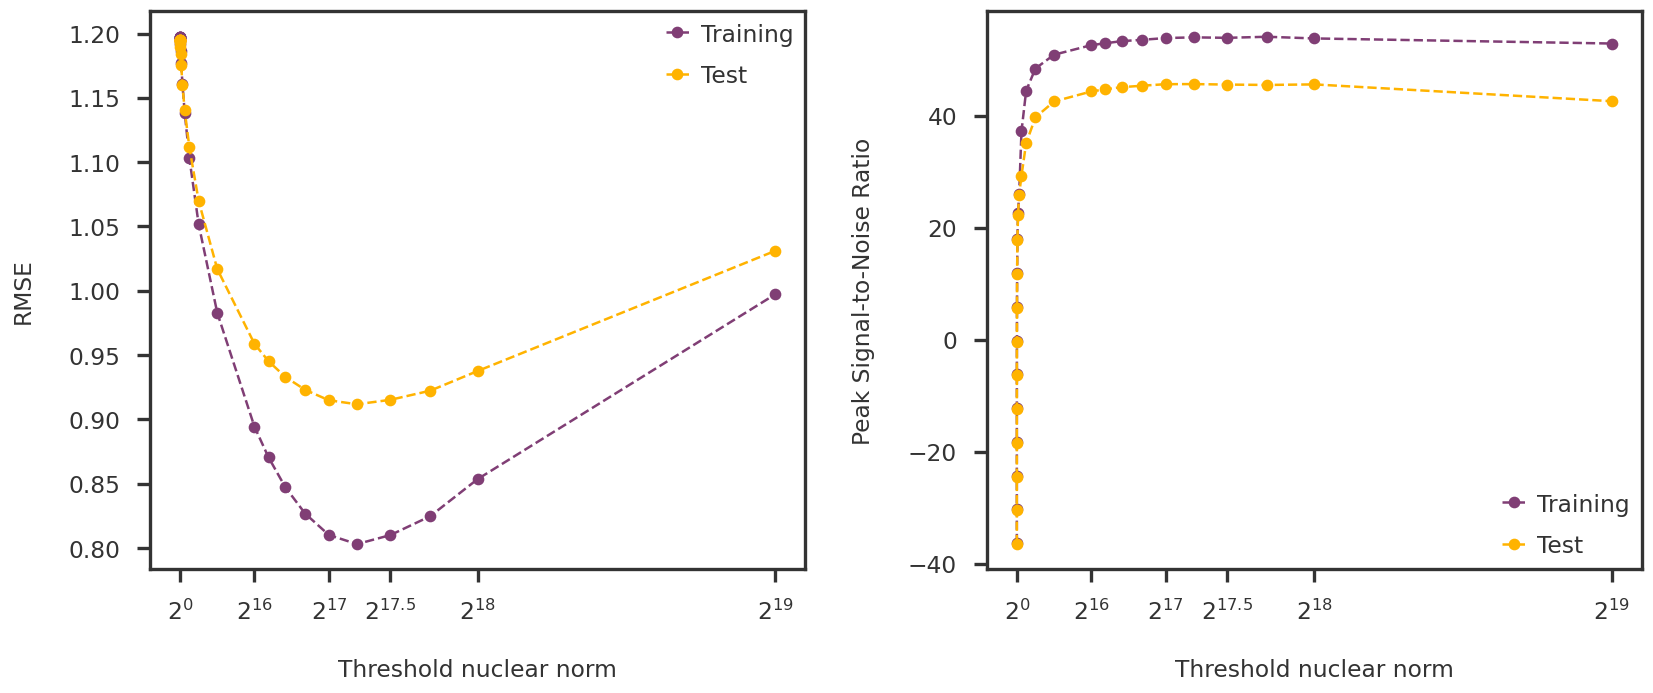

In [9]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(rseq, train_rmse, marker='o', linestyle='dashed', label = "Training")
ax1.plot(rseq, test_rmse, marker='o', linestyle='dashed', label = "Test")
ax1.legend()
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Threshold nuclear norm")
tickmarks = np.array([0, 16, 17, 17.5, 18, 19])
ax1.set_xticks(np.power(2, tickmarks))
ax1.set_xticklabels([r"$2^{" + f"{x:g}" + "}$" for x in tickmarks])


ax2.plot(rseq, train_psnr, marker='o', linestyle='dashed', label = "Training")
ax2.plot(rseq, test_psnr, marker='o', linestyle='dashed', label = "Test")
ax2.legend()
ax2.set_ylabel("Peak Signal-to-Noise Ratio")
ax2.set_xlabel("Threshold nuclear norm")
ax2.set_xticks(np.power(2, tickmarks))
ax2.set_xticklabels([r"$2^{" + f"{x:g}" + "}$" for x in tickmarks])
# mpl_utils.set_xticks(ax1, tickmarks = list(models.keys()))

plt.tight_layout(w_pad = 2.0)
plt.show()

In [11]:
rseq[np.argmin(test_rmse)]

155872.0

In [9]:
nsteps   = [len(model['st_list_']) for r, model in models.items()]
nucnorms = [np.linalg.norm(model['X_'], ord='nuc') for r, model in models.items()]
ranks    = [np.linalg.matrix_rank(model['X_']) for r, model in models.items()]
cputime  = [np.sum(model['cpu_time_']) for r, model in models.items()]

In [10]:
# U = dict()
# S = dict()
# loadings = dict()
# factors = dict()
# for rthres in rseq:
#     rthres_int = int(rthres)
#     rstr = f"{rthres_int:d}"
#     pcout_file = os.path.join(cvout_dir, f"nnm_model_r{rstr}_pcs.npy")
#     with open(pcout_file, "rb") as mfile:
#         U[rthres_int] = np.load(mfile)
#         S[rthres_int] = np.load(mfile)
#         loadings[rthres_int] = np.load(mfile)
#         factors[rthres_int] = np.load(mfile)

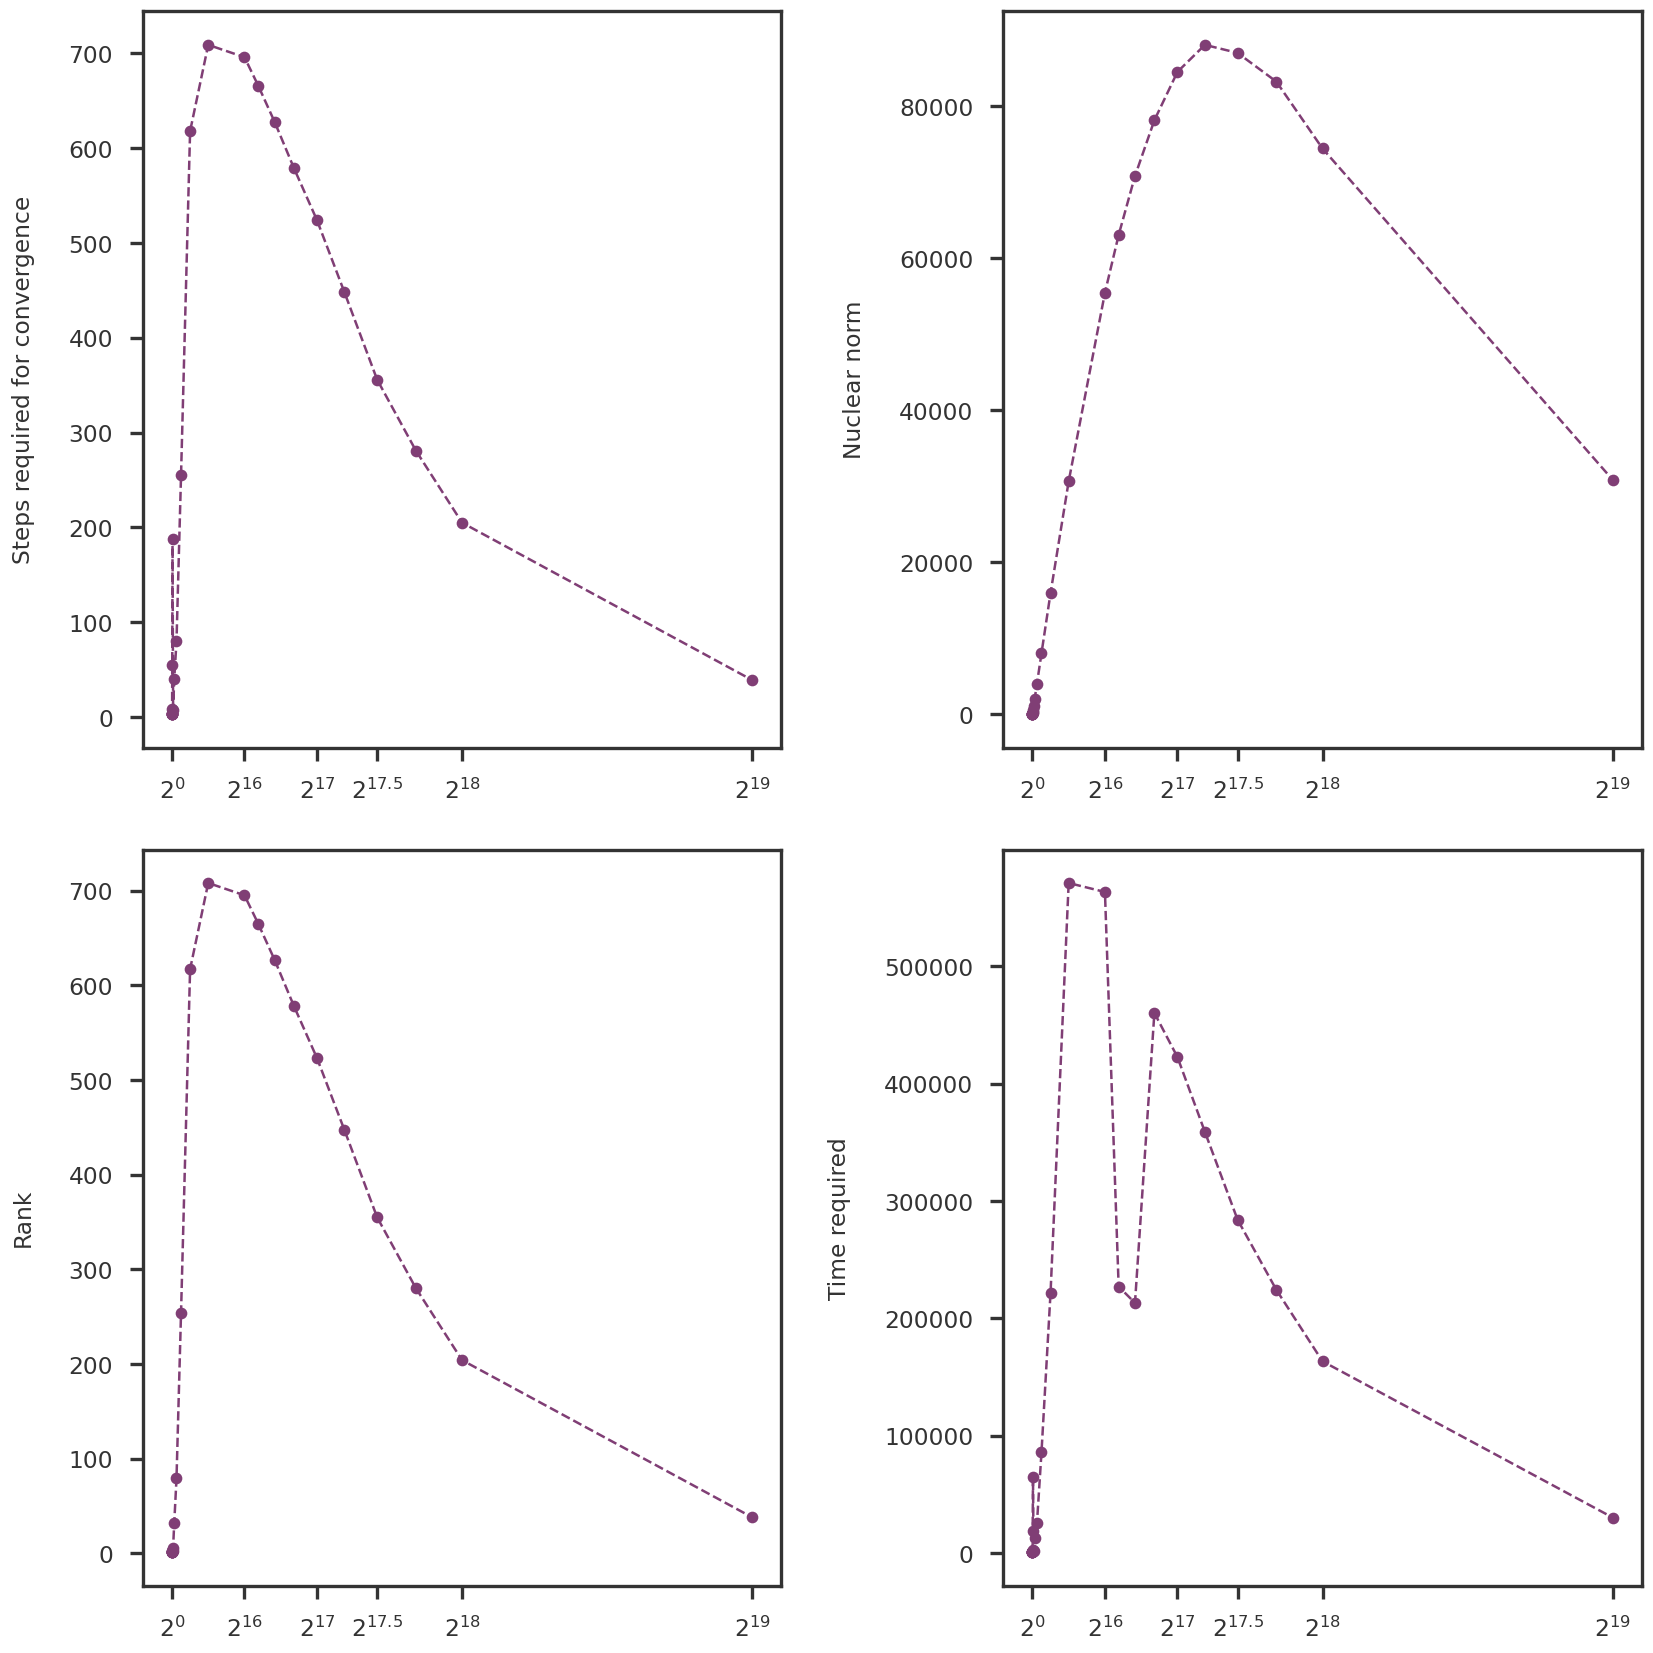

In [11]:
fig = plt.figure(figsize = (14, 14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(rseq, nsteps, marker='o', linestyle='dashed')
ax2.plot(rseq, nucnorms, marker='o', linestyle='dashed')
ax3.plot(rseq, ranks, marker='o', linestyle='dashed')
ax4.plot(rseq, cputime, marker='o', linestyle='dashed')

ax1.set_ylabel("Steps required for convergence")
ax2.set_ylabel("Nuclear norm")
ax3.set_ylabel("Rank")
ax4.set_ylabel("Time required")

tickmarks = np.array([0, 16, 17, 17.5, 18, 19])
for axs in [ax1, ax2, ax3, ax4]:
    axs.set_xticks(np.power(2, tickmarks))
    axs.set_xticklabels([r"$2^{" + f"{x:g}" + "}$" for x in tickmarks])


plt.tight_layout(w_pad = 2.0, h_pad = 2.0)
plt.show()